# VAE Solordinario - Explore Latent Space

In [1]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
latent_dims = 64
num_epochs = 3000
batch_size = 25
capacity = 2
learning_rate = 5e-4
variational_beta = 5e-3
coefPitch=10.
coefLoudness=1.

# Chargement des données 
Utilisation des données de Solordinario et ajout éventuel du dataset supplémentaire créé à partir de VST

In [13]:
import os
import descriptors
import numpy as np

use_homemade_dataset = False

dict_r1 = np.load('data_dict.npy', allow_pickle=True).item()
train_db1 = np.zeros([len(dict_r1['env']),2,750])
i = 0
for sample in dict_r1['env']:
    train_db1[i,:,:] = sample
    i+=1

if use_homemade_dataset == True:
    dict_r2 = np.load('data_dict_jerem_v1.npy', allow_pickle=True).item()
    train_db2 = np.zeros([len(dict_r2['env']),2,750])
    i = 0
    for sample in dict_r2['env']:
        train_db2[i,:,:] = sample
        i+=1
        
    train_db = np.concatenate((train_db1, train_db2)) 
#
 
if use_homemade_dataset == False:
    train_db = train_db1

nb_files, nb_can, nb_samples = np.shape(train_db)

pitches = np.mean(train_db[:,1,:], axis=1)
pitches = np.expand_dims(pitches, axis=1)
pitches = np.broadcast_to(pitches,(nb_files,750))

train_db[:,1,:] = train_db[:,1,:]/pitches[:] #on retire le pitch

MAX1 = np.max(np.abs(train_db[:,0,:]))
MAX2 = np.max(np.abs(train_db[:,1,:]))
train_db[:,0,:] /= MAX1
train_db[:,1,:] /= MAX2
train_dataset =  torch.utils.data.TensorDataset(torch.from_numpy(train_db))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, drop_last = True)
test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, drop_last = True)

# Defintion du VAE 

In [14]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity     
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=2, out_channels=c, kernel_size=10, stride=2, padding=2), nn.BatchNorm1d(c)) # out: c, 372
        self.conv2 = nn.Sequential(nn.Conv1d(in_channels=c, out_channels=c*2, kernel_size=5, stride=2, padding=2), nn.BatchNorm1d(2*c)) # out: c*2, 186
        self.conv3 = nn.Sequential(nn.Conv1d(in_channels=c*2, out_channels=c*4, kernel_size=5, stride=2, padding=2), nn.BatchNorm1d(4*c)) # out: c*2, 186
        self.conv4 = nn.Sequential(nn.Conv1d(in_channels=c*4, out_channels=c*8, kernel_size=5, stride=2, padding=2), nn.BatchNorm1d(8*c)) # out: c*2, 186
        self.conv5 = nn.Sequential(nn.Conv1d(in_channels=c*8, out_channels=c*8, kernel_size=5, stride=1, padding=2), nn.BatchNorm1d(8*c)) # out: c*2, 186
        self.lin1 = nn.Linear(8*c*47, latent_dims*8)
        self.lin2 = nn.Linear(latent_dims*8, latent_dims*4)
        self.fc_mu = nn.Linear(in_features=latent_dims*4, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=latent_dims*4, out_features=latent_dims)
       
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=latent_dims*4)
        self.lin2 = nn.Linear(latent_dims*4, latent_dims*8)
        self.lin3 = nn.Linear(latent_dims*8, 8*c*47)
        self.lin4 = nn.Linear(in_features=750, out_features=750)
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=c*8, out_channels=c*8, kernel_size=5, stride=1, padding=2), nn.BatchNorm1d(8*c))
        self.conv2 = nn.Sequential(nn.Conv1d(in_channels=c*8, out_channels=c*4, kernel_size=5, stride=1, padding=2), nn.BatchNorm1d(4*c)) # out: c*2, 186
        self.conv3 = nn.Sequential(nn.Conv1d(in_channels=c*4, out_channels=c*2, kernel_size=5, stride=1, padding=2), nn.BatchNorm1d(2*c)) # out: c*2, 186
        self.conv4 = nn.Sequential(nn.Conv1d(in_channels=c*2, out_channels=c, kernel_size=5, stride=1, padding=2), nn.BatchNorm1d(c)) # out: c*2, 186
        self.conv5 = nn.Sequential(nn.Conv1d(in_channels=c, out_channels=2, kernel_size=10, stride=1, padding=4)) # out: c, 372
        self.conv6 = nn.Sequential(nn.Conv1d(in_channels=2, out_channels=2, kernel_size=10, stride=1, padding=4)) # out: c, 372
        self.upsample1 = nn.Upsample(scale_factor=2, mode="nearest")
        self.upsamplef = nn.Upsample(size=752, mode="nearest")

            
    def forward(self, x):
        x = F.relu(self.fc(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        x = x.view(x.size(0), capacity*8, 47) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv1(x))
        x = self.upsample1(x)
        x = F.relu(self.conv2(x))
        x = self.upsample1(x)
        x = F.relu(self.conv3(x))
        x = self.upsample1(x)
        x = F.relu(self.conv4(x))
        x = self.upsamplef(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = torch.sigmoid(self.lin4(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
        
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = (coefLoudness*F.mse_loss(recon_x[:,0,:], x[:,0,:], reduction='sum')+coefPitch*F.mse_loss(recon_x[:,1,:], x[:,1,:], reduction='sum'))/np.size(batch_size)
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())/np.size(batch_size)  
    return recon_loss + variational_beta * kldivergence, recon_loss, variational_beta * kldivergence
    
vae = VariationalAutoencoder()

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 1651602


# Reconstruction 

In [15]:
#Load des valeurs de modèles pré-entrainé
vae.load_state_dict(torch.load('vaeMODELtrainedOK'))

<All keys matched successfully>

In [16]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# En entrée, l'image à reconstruire et le modèle utilisé pour la reconstruction

index_list = [10,20,30,40,50,60]
index_list = list(range(12))

list_sources = [[train_db[i,0,:]*MAX1,train_db[i,1,:]*pitches[i]*MAX2] for i in index_list]

list_images = []
for i in index_list:
    images = train_db[i,:,:]
    images_recon,_,_ = vae(torch.from_numpy(images).view(1,2,750).float())
    images_recon = images_recon.detach().numpy()
    list_images.append([images_recon[0,0,:]*MAX1,(images_recon[0,1,:]*(pitches[i])*MAX2)])

## Visualisation : 

In [17]:
from visualizer import Visualizer
V = Visualizer(list_images,list_sources) 

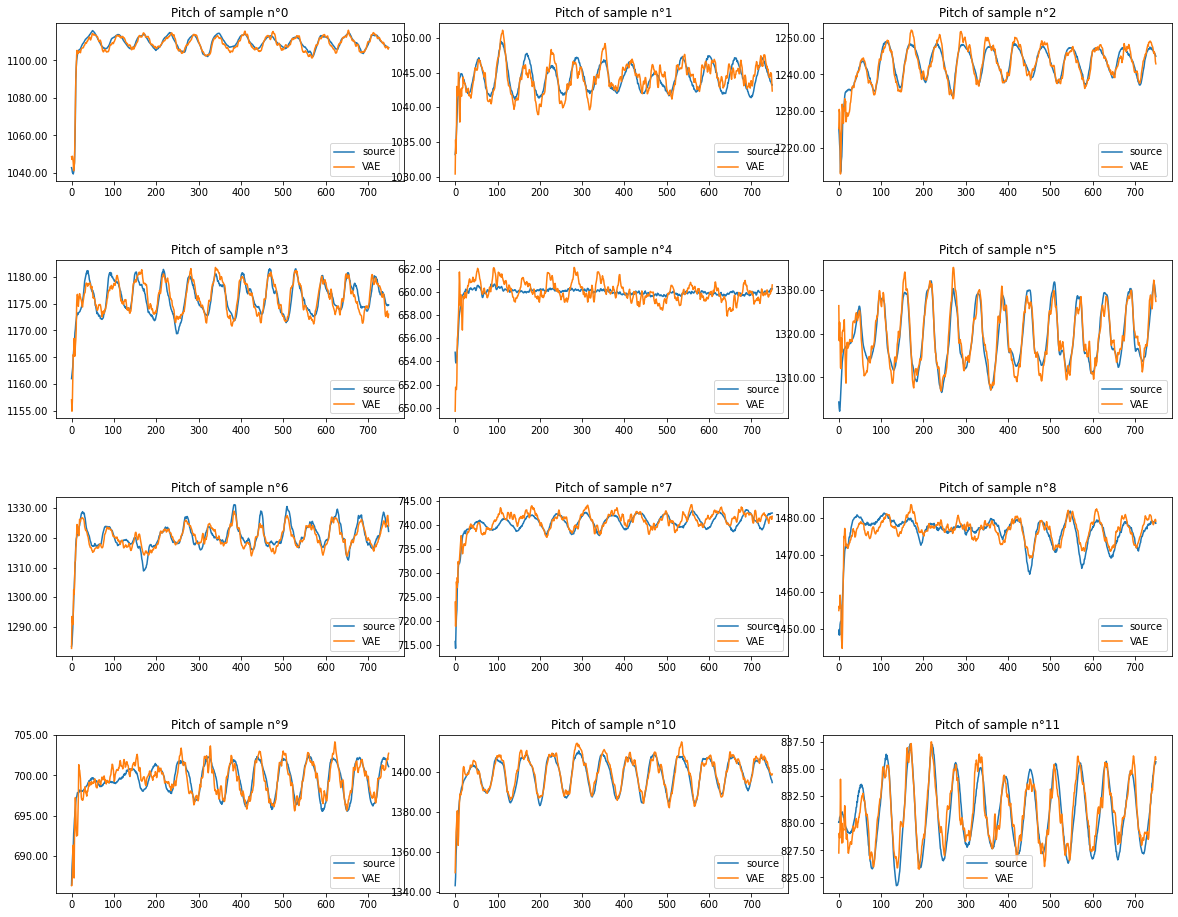

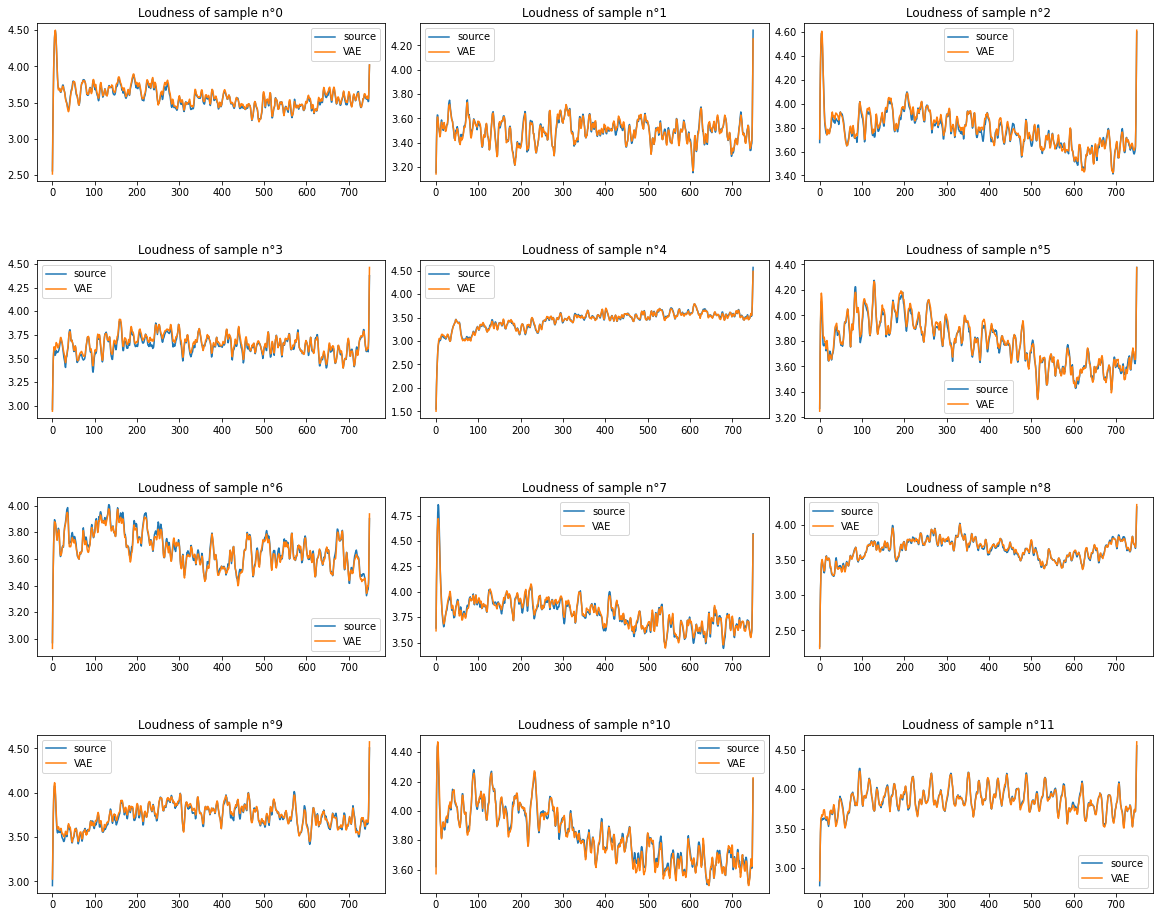

In [18]:
V.show_pitch()
V.show_loudness()

### DDSP pour écouter résultats

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


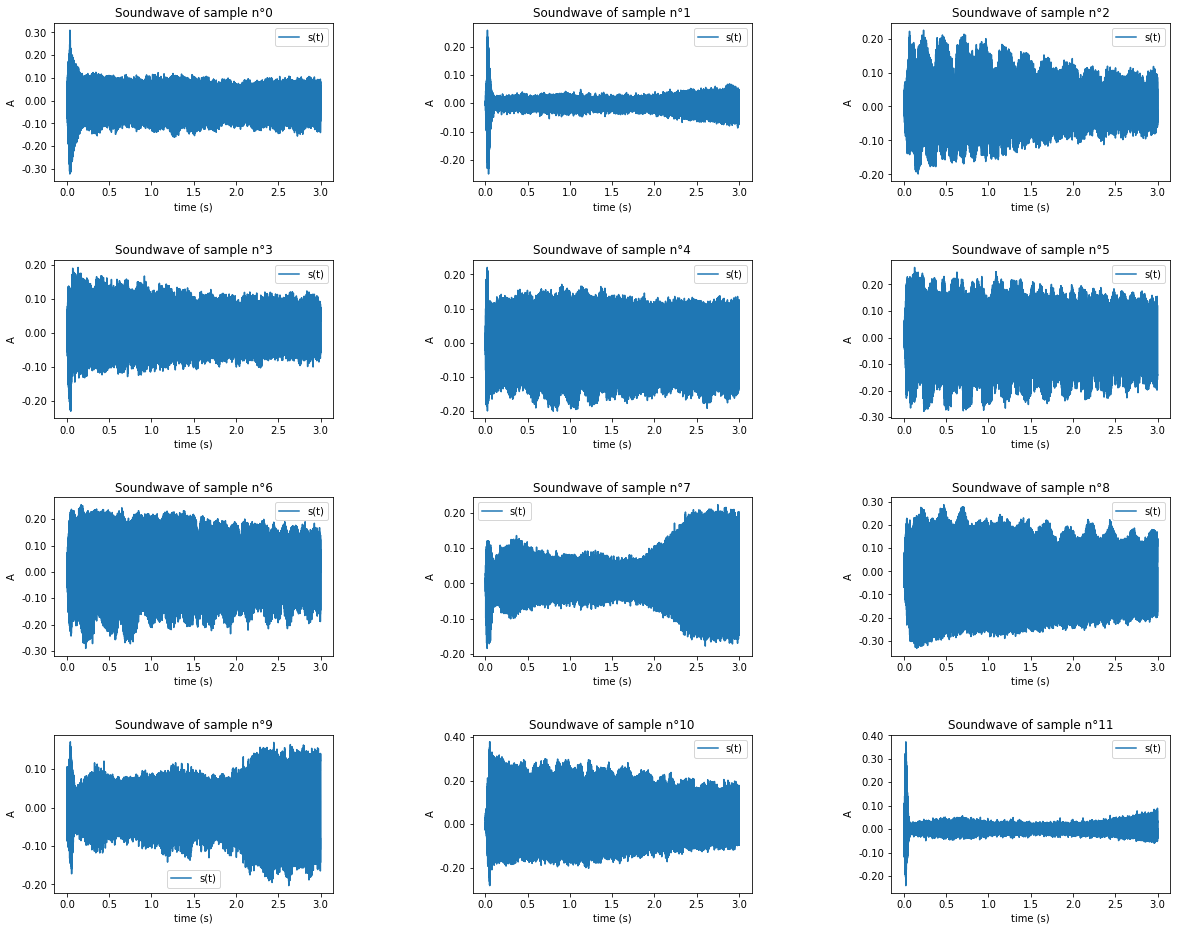

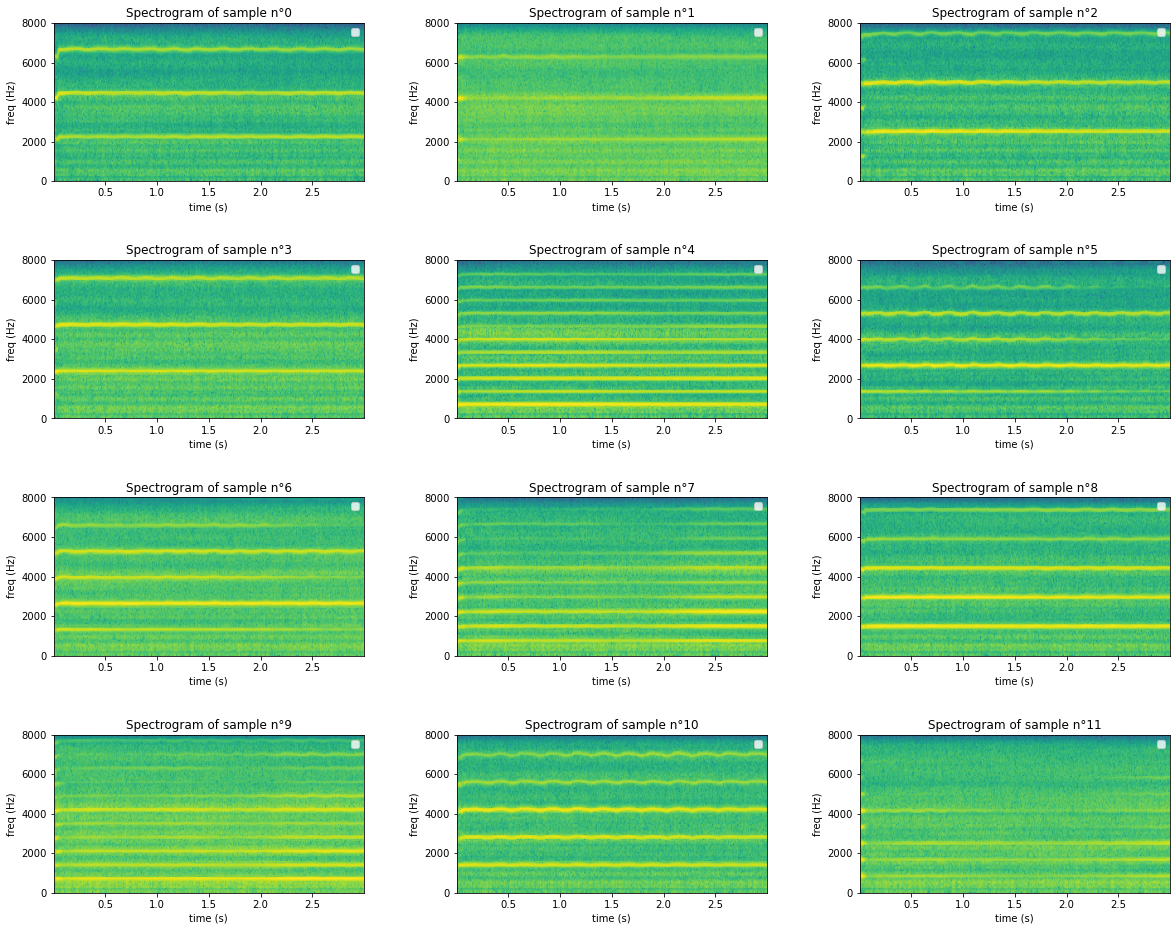

In [19]:
ddsp = torch.jit.load('ddsp_solordinario_pretrained.ts')
V.reconstruction(ddsp)
V.show_sound()
V.show_spectrogramm()

## Écoute des sons obtenus : 

In [20]:
V.listen(5)

## Interpolation dans l'espace latent

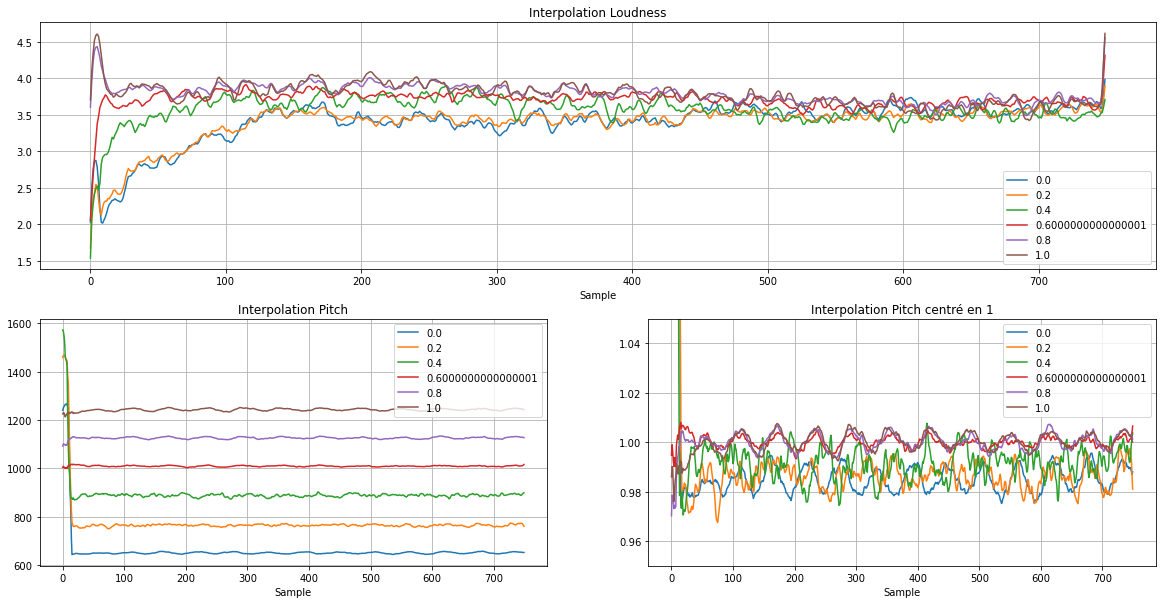

In [32]:
vae.eval()

def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
    
        # latent vector of first image
        latent_1, _ = model.encoder(img1)

        # latent vector of second image
        latent_2, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)

        return inter_image, inter_latent
    


# interpolation lambdas
lambda_range=np.linspace(0,1,6)
list_int = [[train_db[2,0,:]*MAX1,train_db[2,1,:]*pitches[2]*MAX2]]

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(224)

ax1.set_xlabel('Sample')
ax2.set_xlabel('Sample')
ax3.set_xlabel('Sample')

for ind,l in enumerate(lambda_range):
    
    inter_image,lat = interpolation(float(l), vae, torch.from_numpy(train_db[2,:,:]).view(1,2,750).float(), torch.from_numpy(train_db[168,:,:]).view(1,2,750).float())
    inter_image = inter_image.detach().numpy()
    
    list_int.append([inter_image[0,0,:]*MAX1,(inter_image[0,1,:]*MAX2*((pitches[2]*l+pitches[165]*(1-l))))])
    
    ax1.plot(inter_image[0,0,:]*MAX1, label=str(l))
    ax2.plot(inter_image[0,1,:]*MAX2*(pitches[2]*l+pitches[165]*(1-l)), label=str(l))
    ax3.plot(inter_image[0,1,:]/np.mean(inter_image[0,1,:]), label=str(l))
    

#    

ax1.set_title('Interpolation Loudness')
ax1.legend()
ax1.grid()
ax2.set_title('Interpolation Pitch')
ax2.legend()
ax2.grid()
ax3.set_title('Interpolation Pitch centré en 1')
ax3.set_ylim((0.95, 1.05))
ax3.legend()
ax3.grid()
   

In [22]:
V = Visualizer(list_int[1:]) 

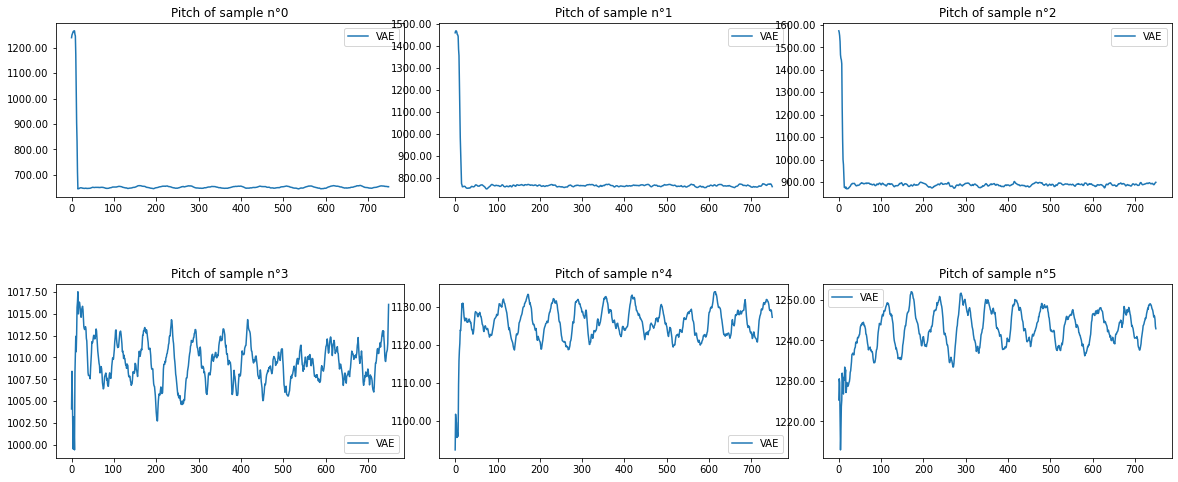

In [23]:
V.show_pitch()

In [24]:
ddsp = torch.jit.load('ddsp_solordinario_pretrained.ts')
V.reconstruction(ddsp)

In [25]:
#Chose Indice To Listen
V.listen(0)

## Observation de schéma dans l'espace Latent

(252, 64)


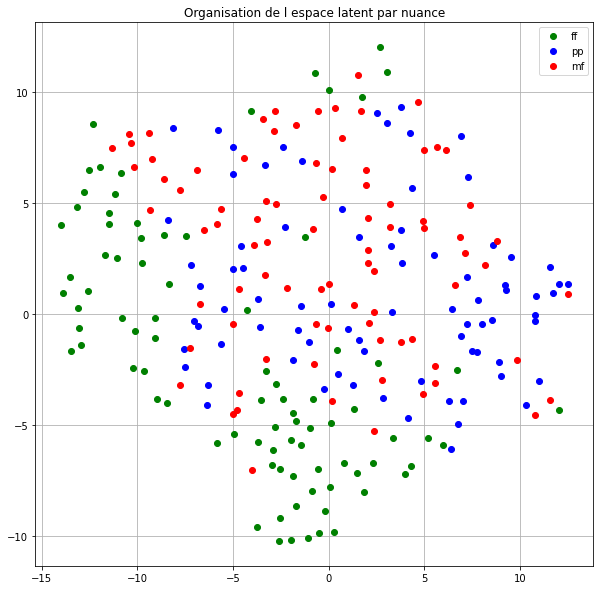

In [26]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = TSNE(n_components=2)

vae.eval()

arg_ff = [i for i, x in enumerate(dict_r1['vel']) if x == "ff"]
latent_val_ff,_ = vae.encoder(torch.from_numpy(train_db[arg_ff,:,:]).view(len(arg_ff),2,750).float())

arg_pp = [i for i, x in enumerate(dict_r1['vel']) if x == "pp"]
latent_val_pp,_ = vae.encoder(torch.from_numpy(train_db[arg_pp,:,:]).view(len(arg_pp),2,750).float())


arg_mf = [i for i, x in enumerate(dict_r1['vel']) if x == "mf"]
latent_val_mf,_ = vae.encoder(torch.from_numpy(train_db[arg_mf,:,:]).view(len(arg_mf),2,750).float())

latent_ff = latent_val_ff.detach().numpy()
latent_pp = latent_val_pp.detach().numpy()
latent_mf = latent_val_mf.detach().numpy()

latent_val = np.concatenate((latent_ff, latent_pp, latent_mf), axis=0)
 
print(np.shape(latent_val))

x = pca.fit_transform(latent_val)

plt.figure(figsize=(10,10))
plt.plot(x[:86,0], x[:86,1], 'og', label='ff')
plt.plot(x[87:167,0], x[87:167,1], 'ob', label='pp')
plt.plot(x[167:,0], x[167:,1], 'or', label='mf')
plt.legend()
plt.title('Organisation de l espace latent par nuance')
plt.grid()

In [27]:
NOTES_FLAT = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']
NOTES_SHARP = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

def NoteToMidi(KeyOctave):
    # KeyOctave is formatted like 'C#3'
    key = KeyOctave[:-1]  # eg C, Db
    octave = KeyOctave[-1]   # eg 3, 4
    answer = -1

    try:
        if 'b' in key:
            pos = NOTES_FLAT.index(key)
        else:
            pos = NOTES_SHARP.index(key)
    except:
        print('The key is not valid', key)
        return answer

    answer += pos + 12 * (int(octave) + 1) + 1
    return answer

pitch_midi = np.zeros(nb_files)

for i in range(nb_files):
    pitch_midi[i] = NoteToMidi(dict_r1['pitch'][i])

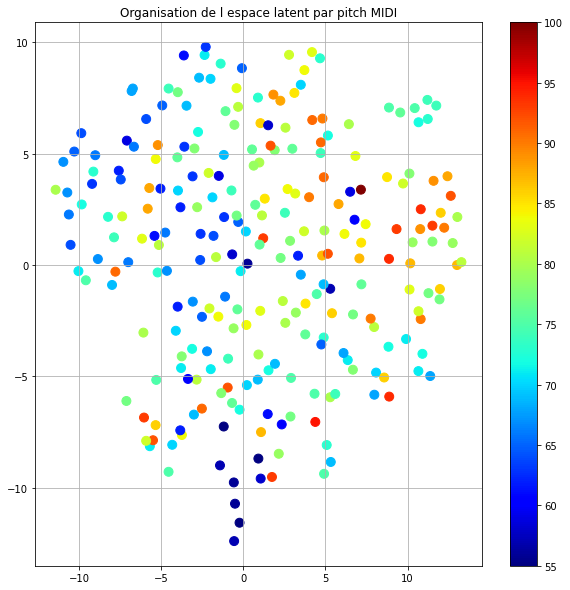

In [28]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = TSNE(n_components=2)

vae.eval()

latent_val,_ = vae.encoder(torch.from_numpy(train_db).view(nb_files,2,750).float())
latent_val = latent_val.detach().numpy()

x = pca.fit_transform(latent_val)

plt.figure(figsize=(10,10))
plt.scatter(x[:,0], x[:,1], c=pitch_midi, cmap='jet', s=80)
plt.title('Organisation de l espace latent par pitch MIDI')
plt.grid()
plt.colorbar()

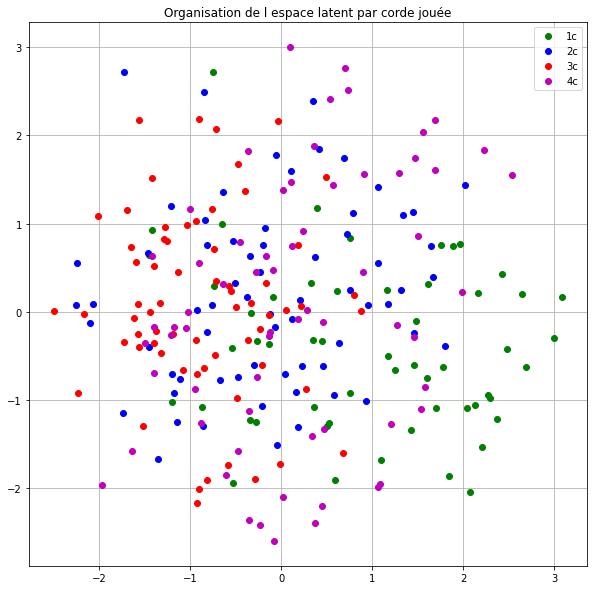

In [29]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)

vae.eval()

arg_1 = [i for i, x in enumerate(dict_r1['corde']) if x == "1c"]
latent_val_1,_ = vae.encoder(torch.from_numpy(train_db[arg_1,:,:]).view(len(arg_1),2,750).float())

arg_2 = [i for i, x in enumerate(dict_r1['corde']) if x == "2c"]
latent_val_2,_ = vae.encoder(torch.from_numpy(train_db[arg_2,:,:]).view(len(arg_2),2,750).float())

arg_3 = [i for i, x in enumerate(dict_r1['corde']) if x == "3c"]
latent_val_3,_ = vae.encoder(torch.from_numpy(train_db[arg_3,:,:]).view(len(arg_3),2,750).float())

arg_4 = [i for i, x in enumerate(dict_r1['corde']) if x == "4c"]
latent_val_4,_ = vae.encoder(torch.from_numpy(train_db[arg_4,:,:]).view(len(arg_4),2,750).float())

latent_1 = latent_val_1.detach().numpy()
latent_2 = latent_val_2.detach().numpy()
latent_3 = latent_val_3.detach().numpy()
latent_4 = latent_val_4.detach().numpy()

latent_val = np.concatenate((latent_1, latent_2, latent_3, latent_4), axis=0)

x = pca.fit_transform(latent_val)

plt.figure(figsize=(10,10))
plt.plot(x[:55,0], x[:55,1], 'og', label='1c')
plt.plot(x[55:122,0], x[55:122,1], 'ob', label='2c')
plt.plot(x[122:187,0], x[122:187,1], 'or', label='3c')
plt.plot(x[187:,0], x[187:,1], 'om', label='4c')
plt.legend()
plt.title('Organisation de l espace latent par corde jouée')
plt.grid()